## **Step 1: Setting Up the Environment**  


In [1]:
!pip install torch torchvision matplotlib tqdm

## **Step 2: Loading the Dataset**

We’ll use `torchvision.datasets` to load the **FashionMNIST** dataset

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),                   # Resize images to 224x224
    transforms.Grayscale(num_output_channels=3),       # Convert grayscale to 3 channels
    transforms.ToTensor(),

])

# Load FashionMNIST Dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

100%|██████████| 26.4M/26.4M [00:01<00:00, 18.3MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 271kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.06MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 11.3MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Number of training samples: 60000
Number of test samples: 10000


# **Step 3: Loading and Modifying the Pre-trained Model**

**EfficientNet-B0**


In [3]:
import torchvision.models as models
import torch.nn as nn

# Load pre-trained efficientnet_b0 model
model = models.efficientnet_b0(pretrained=True)

# Modify the classifier layer for 10 classes (FashionMNIST)
num_ftrs = model.classifier[1].in_features  # Input features to the classifier layer
model.classifier[1] = nn.Linear(num_ftrs, 10)  # Replace with a new linear layer

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 134MB/s] 


## **Step 4: Defining the Loss Function and Optimizer**

In [4]:
import torch.optim as optim

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

## **Step 5: Training the Model**

We’ll now write the training loop:

In [5]:
from tqdm import tqdm

# Training loop
def train_model(model, train_loader, criterion, optimizer, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

# Run training
train_model(model, train_loader, criterion, optimizer, device, epochs=10)

Epoch 1/10: 100%|██████████| 938/938 [06:06<00:00,  2.56it/s]


Epoch 1, Loss: 0.4370


Epoch 2/10: 100%|██████████| 938/938 [06:13<00:00,  2.51it/s]


Epoch 2, Loss: 0.2874


Epoch 3/10: 100%|██████████| 938/938 [06:13<00:00,  2.51it/s]


Epoch 3, Loss: 0.2497


Epoch 4/10: 100%|██████████| 938/938 [06:30<00:00,  2.40it/s]


Epoch 4, Loss: 0.2251


Epoch 6/10: 100%|██████████| 938/938 [06:13<00:00,  2.51it/s]


Epoch 6, Loss: 0.1993


Epoch 7/10: 100%|██████████| 938/938 [06:13<00:00,  2.51it/s]


Epoch 7, Loss: 0.1862


Epoch 8/10: 100%|██████████| 938/938 [06:12<00:00,  2.52it/s]


Epoch 8, Loss: 0.1759


Epoch 9/10: 100%|██████████| 938/938 [06:13<00:00,  2.51it/s]


Epoch 9, Loss: 0.1630


Epoch 10/10: 100%|██████████| 938/938 [06:13<00:00,  2.51it/s]

Epoch 10, Loss: 0.1501


## **Step 6: Evaluating the Model**

Now, let’s evaluate the model’s accuracy on the test dataset:

In [6]:
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# Evaluate the model
test_accuracy = evaluate_model(model, test_loader, device)

Test Accuracy: 91.66%


# **Let's try to predict !!**

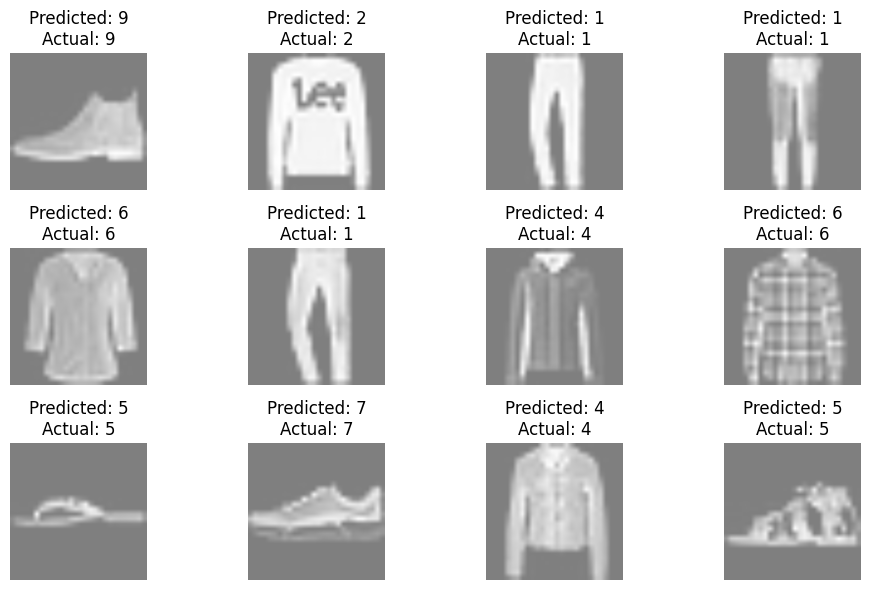

In [7]:
import matplotlib.pyplot as plt
import torch

def plot_predictions(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        images, labels = next(iter(test_loader))
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    fig = plt.figure(figsize=(10, 6))
    for i in range(12):
        ax = fig.add_subplot(3, 4, i + 1)
        ax.imshow(images[i].cpu().squeeze().permute(1, 2, 0) / 2 + 0.5) # Assuming normalization
        ax.set_title(f"Predicted: {predicted[i].item()}\nActual: {labels[i].item()}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_predictions(model, test_loader, device)